# Studying the convective layer

The equations for the Lengyel model hold throughout most of the domain, except for a small region close to the divertor target. We'll develop regressions for the power and pressure loss in that region.

In [1]:
## Every notebook should start with this header
# The next lines mean that changes in Python files are instantaneously applied
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")

import cfspopcon
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cfspopcon.unit_handling import magnitude_in_units, ureg

import extended_lengyel

Running in /Users/tbody/Projects/raddivmom2/notebooks


In [2]:
def build_rcc_dataset(
    run_rcc_model_to_cc_interface = False,
    **overrides
):
    if run_rcc_model_to_cc_interface: 
        algorithm = cfspopcon.Algorithm.get_algorithm("kallenbach_model_to_cc")

    else:
        algorithm = cfspopcon.Algorithm.get_algorithm("kallenbach_model")

    ds = xr.Dataset(data_vars=extended_lengyel.read_config(
        elements=["base", "target_constraints"],
        keys=algorithm.input_keys,
        allowed_missing=algorithm.default_keys,
        overrides=overrides,
    ))

    algorithm.validate_inputs(ds)
    ds = algorithm.update_dataset(ds)

    return ds

## Fitting curves for the power and momentum loss

We fit curves of the form given in Equation 33 from Stangeby, 2018, PPCF 60 044022

$f = 1.0 - A \left[1.0 - \exp\left[-T_{e,t} / w\right]\right]^S$

These were originally used for the momentum loss, but we find that this fit function works reasonably well for the power loss as well.

Fitting fmom
Covariance matrix condition number: 3762.2752580699457, diagonal elements: [7.66737433e-07 1.31802533e-03 5.44994584e-05]
amplitude: 0.886 \pm 0.0009
width: 3.83 \pm 0.04
shape: 0.828 \pm 0.007
Fitting fpow
Covariance matrix condition number: 4688.293883850964, diagonal elements: [3.69667124e-06 7.19271658e-03 1.91615417e-04]
amplitude: 0.853 \pm 0.002
width: 5.2 \pm 0.08
shape: 0.964 \pm 0.01
Fitting fdens
Covariance matrix condition number: 5470.960243452165, diagonal elements: [4.90560408e-07 1.19905043e-03 4.14710272e-04]
amplitude: 0.559 \pm 0.0007
width: 2.02 \pm 0.03
shape: 0.96 \pm 0.02


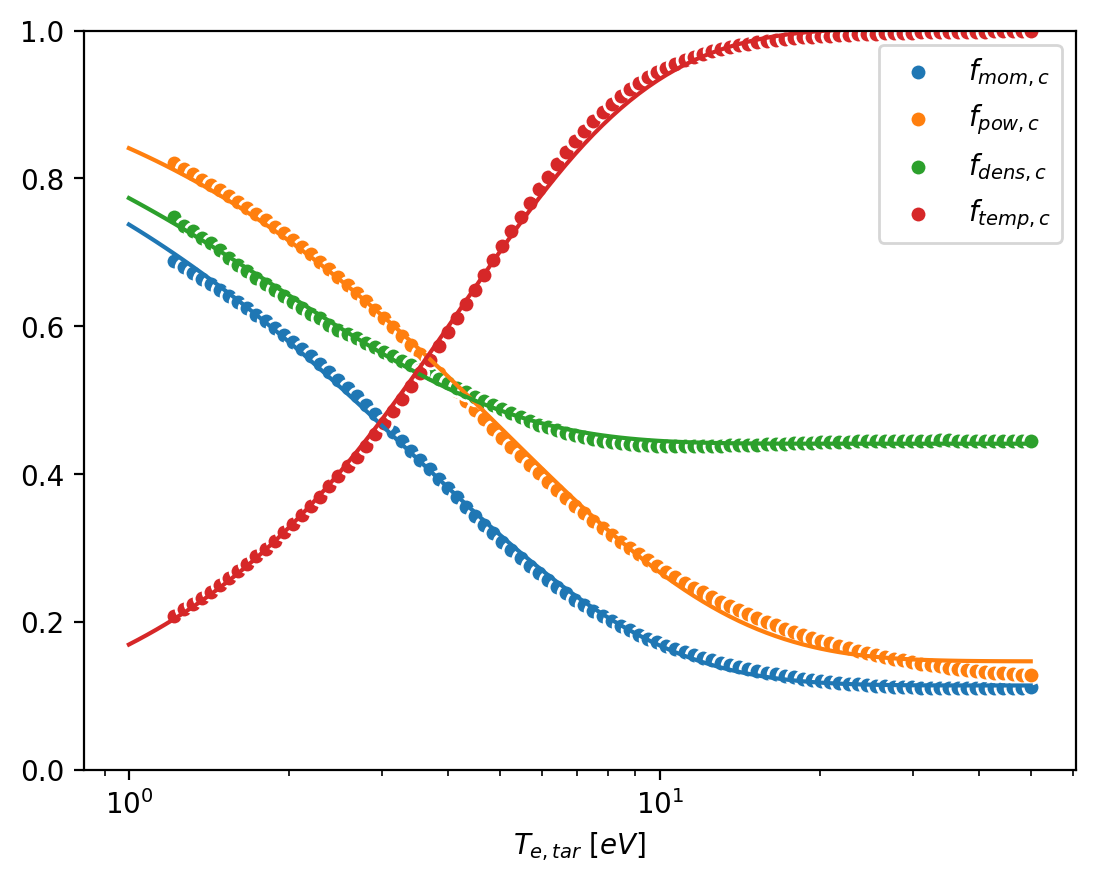

In [3]:
import yaml
from cfspopcon.unit_handling import magnitude_in_units as umag
from scipy.optimize import curve_fit

from extended_lengyel.extended_lengyel_model.convective_loss_fits import temperature_fit_function


def determine_temperature_fit_coefficients(x, y, info=True):
    """Fit a temperature-fit function to the data."""
    popt, pcov = curve_fit(
        temperature_fit_function,
        xdata = x.where(~np.isnan(y), drop=True),
        ydata = y.where(~np.isnan(y), drop=True),
    )

    p_sigma = np.sqrt(np.diag(pcov))

    if info:
        print(f"Covariance matrix condition number: {np.linalg.cond(pcov)}, diagonal elements: {np.diag(pcov)}")
        print(
            f"amplitude: {popt[0]:.3g} \\pm {p_sigma[0]:.1g}\n"
            f"width: {popt[1]:.3g} \\pm {p_sigma[1]:.1g}\n"
            f"shape: {popt[2]:.3g} \\pm {p_sigma[2]:.1g}"
        )

    coeffs = dict(
        amplitude = float(popt[0]),
        width = float(popt[1]),
        shape = float(popt[2]),
        amplitude_uncertainty = float(p_sigma[0]),
        width_uncertainty = float(p_sigma[1]),
        shape_uncertainty = float(p_sigma[2]),
    )

    return coeffs, lambda x: temperature_fit_function(x, *popt)

def determine_fmomc_and_fpowc_fit_functions(ds, info=False, save=False, plot=False):
    """Determine fit functions for the momentum and power loss in the convective layer near the target."""
    x = umag(ds["target_electron_temp"], ureg.eV)
    fmom = ds["SOL_momentum_loss_fraction_in_convection_layer"]
    fpow = ds["SOL_power_loss_fraction_in_convection_layer"]
    ftemp = ds["electron_temp_ratio_in_convection_layer"]
    fdens = ds["electron_density_ratio_in_convection_layer"]

    if info: print("Fitting fmom")
    fmom_coeffs, fmom_fit = determine_temperature_fit_coefficients(x, umag(fmom, ureg.dimensionless), info=info)
    if info: print("Fitting fpow")
    fpow_coeffs, fpow_fit = determine_temperature_fit_coefficients(x, umag(fpow, ureg.dimensionless), info=info)
    if info: print("Fitting fdens")
    fdens_coeffs, fdens_fit = determine_temperature_fit_coefficients(x, umag(fdens, ureg.dimensionless), info=info)

    data = dict(
        fmom_coeffs = fmom_coeffs,
        fpow_coeffs = fpow_coeffs,
        fdens_coeffs = fdens_coeffs,
    )

    if save:
        with open(extended_lengyel.directories.module_directory / "curve_fit.yml", "w") as outfile:
            yaml.dump(data, outfile)

    if plot:
        fig, ax = plt.subplots(dpi=200)

        fmom.plot.scatter(xscale="log", label="$f_{mom,c}$")
        fmom_fit(x).plot()

        fpow.plot.scatter(xscale="log", label="$f_{pow,c}$")
        fpow_fit(x).plot()

        fdens.plot.scatter(xscale="log", label="$f_{dens,c}$")
        fdens_fit(x).plot()

        ftemp.plot.scatter(xscale="log", label="$f_{temp,c}$")
        (0.5 * (1 - fmom_fit(x)) / fdens_fit(x)).plot()

        ax.legend()
        ax.set_xlabel("$T_{e,tar}$ [$eV$]")
        ax.set_ylabel("")
        ax.set_ylim(0, 1)

    return data

rcc_target_electron_temp_scan_for_fit = build_rcc_dataset(
    heat_flux_perp_to_target = 1.0 * ureg.MW / ureg.m**2,
    target_electron_temp  = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1.0), np.log10(50), num=100), ureg.eV, dims="target_electron_temp"),
    impurity_fraction        = 1.0 * ureg.percent,
    run_rcc_model_to_cc_interface = True,
)

reference_fit_coeffs = determine_fmomc_and_fpowc_fit_functions(rcc_target_electron_temp_scan_for_fit, info=True, save=True, plot=True)

## Parametrizing the power and momentum loss in the convective layer

The electron temperature has a strong effect on the momentum and power loss in the convective layer. The residual power flux to the target has some small effect, and the impurity fraction has almost no effect.

In [4]:
rcc_target_electron_temp_scan = build_rcc_dataset(
    heat_flux_perp_to_target = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(0.1), np.log10(10.0), num=3), ureg.MW / ureg.m**2, dims="heat_flux_perp_to_target"),
    target_electron_temp  = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1.0), np.log10(50), num=100), ureg.eV, dims="target_electron_temp"),
    impurity_fraction        = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(0.1), np.log10(10), num=3), ureg.percent, dims="impurity_fraction"),
    run_rcc_model_to_cc_interface = True
)

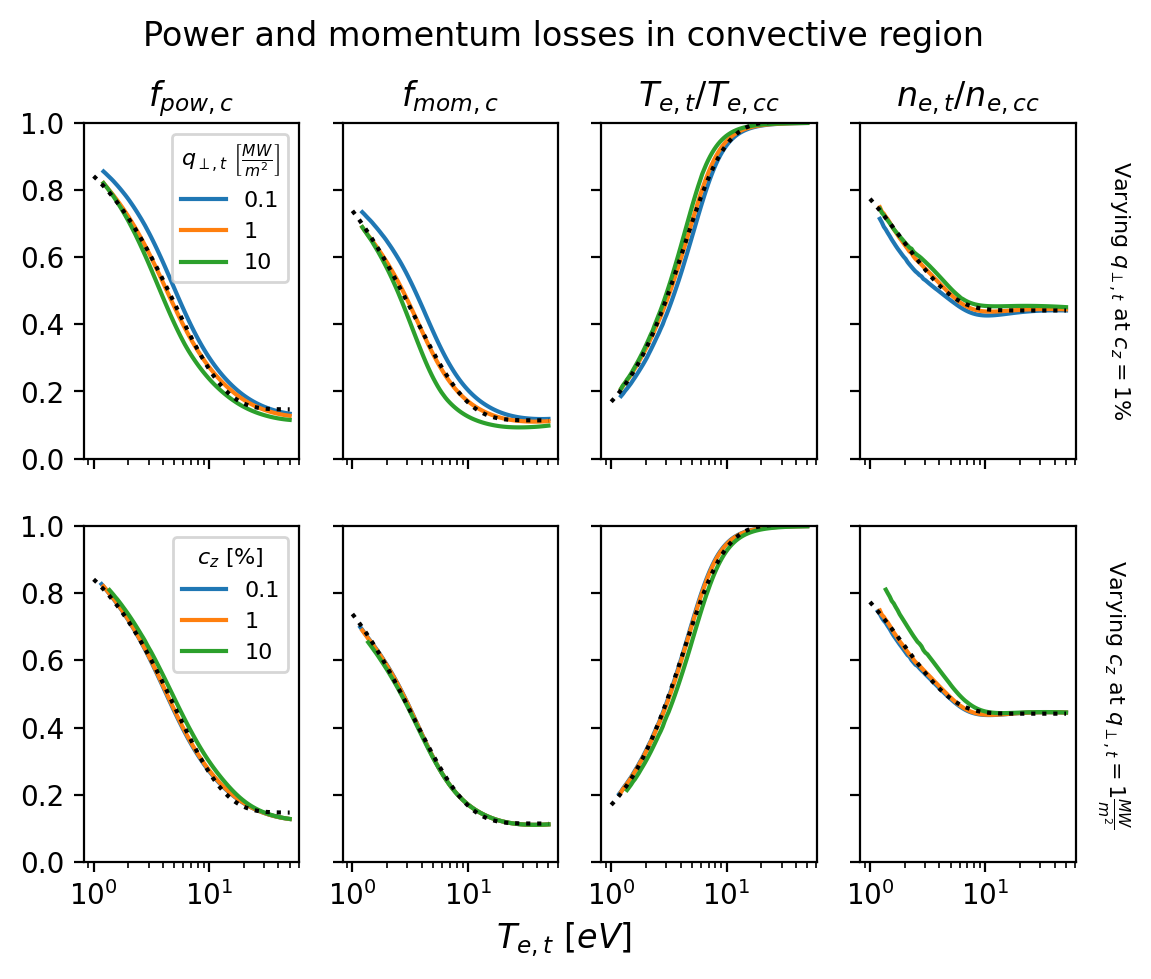

In [5]:
import extended_lengyel.directories


fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, dpi=200)

for val in np.logspace(np.log10(0.1), np.log10(10.0), num=3):

    rcc_target_electron_temp_scan["SOL_power_loss_fraction_in_convection_layer"].sel(dim_impurity_fraction=1.0, dim_heat_flux_perp_to_target=val).plot.line(ax=axs[0][0], add_legend=False, label=f"{val:.2g}")
    rcc_target_electron_temp_scan["SOL_power_loss_fraction_in_convection_layer"].sel(dim_impurity_fraction=val, dim_heat_flux_perp_to_target=1.0).plot.line(ax=axs[1][0], add_legend=False, label=f"{val:.2g}")

    rcc_target_electron_temp_scan["SOL_momentum_loss_fraction_in_convection_layer"].sel(dim_impurity_fraction=1.0, dim_heat_flux_perp_to_target=val).plot.line(ax=axs[0][1], add_legend=False, label=f"{val:.2g}")
    rcc_target_electron_temp_scan["SOL_momentum_loss_fraction_in_convection_layer"].sel(dim_impurity_fraction=val, dim_heat_flux_perp_to_target=1.0).plot.line(ax=axs[1][1], add_legend=False, label=f"{val:.2g}")

    rcc_target_electron_temp_scan["electron_temp_ratio_in_convection_layer"].sel(dim_impurity_fraction=1.0, dim_heat_flux_perp_to_target=val).plot.line(ax=axs[0][2], add_legend=False, label=f"{val:.2g}")
    rcc_target_electron_temp_scan["electron_temp_ratio_in_convection_layer"].sel(dim_impurity_fraction=val, dim_heat_flux_perp_to_target=1.0).plot.line(ax=axs[1][2], add_legend=False, label=f"{val:.2g}")

    rcc_target_electron_temp_scan["electron_density_ratio_in_convection_layer"].sel(dim_impurity_fraction=1.0, dim_heat_flux_perp_to_target=val).plot.line(ax=axs[0][3], add_legend=False, label=f"{val:.2g}")
    rcc_target_electron_temp_scan["electron_density_ratio_in_convection_layer"].sel(dim_impurity_fraction=val, dim_heat_flux_perp_to_target=1.0).plot.line(ax=axs[1][3], add_legend=False, label=f"{val:.2g}")

with open(extended_lengyel.directories.module_directory / "curve_fit.yml") as infile:
    data = yaml.safe_load(infile)

fmom_fit = temperature_fit_function(
    target_electron_temp=rcc_target_electron_temp_scan["target_electron_temp"],
    amplitude=data["fmom_coeffs"]["amplitude"],
    width=data["fmom_coeffs"]["width"] * ureg.eV,
    shape=data["fmom_coeffs"]["shape"],
)

fpow_fit = temperature_fit_function(
    target_electron_temp=rcc_target_electron_temp_scan["target_electron_temp"],
    amplitude=data["fpow_coeffs"]["amplitude"],
    width=data["fpow_coeffs"]["width"] * ureg.eV,
    shape=data["fpow_coeffs"]["shape"],
)

fdens_fit = temperature_fit_function(
    target_electron_temp=rcc_target_electron_temp_scan["target_electron_temp"],
    amplitude=data["fdens_coeffs"]["amplitude"],
    width=data["fdens_coeffs"]["width"] * ureg.eV,
    shape=data["fdens_coeffs"]["shape"],
)

for i, fit in zip([0, 1, 3], [fpow_fit, fmom_fit, fdens_fit]):
    for ax in axs[:, i]:
        ax.plot(fit["dim_target_electron_temp"], fit, color="k", linestyle=":")

for ax in axs[:, 2]:
    ax.plot(fmom_fit["dim_target_electron_temp"], (0.5 * (1 - fmom_fit) / fdens_fit), color="k", linestyle=":")

for ax in axs.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")

axs[0, 0].legend(loc="upper right", fontsize=8, title="$q_{\\perp,t}$ $\\left[\\frac{MW}{m^2}\\right]$", title_fontsize=8)
axs[1, 0].legend(loc="upper right", fontsize=8, title="$c_{z}$ $[\\%]$", title_fontsize=8)
axs[0, -1].yaxis.set_label_position("right")
axs[1, -1].yaxis.set_label_position("right")
axs[0, -1].set_ylabel("Varying $q_{\\perp,t}$ at $c_z=1\\%$", rotation=270, labelpad=20, fontsize=8)
axs[1, -1].set_ylabel("Varying $c_z$ at $q_{\\perp,t}=1\\frac{MW}{m^2}$", rotation=270, labelpad=20, fontsize=8)

axs[0][0].set_xscale("log")
axs[0][0].set_ylim(0, 1.0)

fig.text(0.5, 0.02, "$T_{e,t}$ [$eV$]", ha="center", fontsize=12)
fig.text(0.5, 0.96, "Power and momentum losses in convective region", ha="center", fontsize=12)

axs[0][0].set_title("$f_{pow,c}$", fontsize=12)
axs[0][1].set_title("$f_{mom,c}$", fontsize=12)
axs[0][2].set_title("$T_{e,t}/T_{e,cc}$", fontsize=12)
axs[0][3].set_title("$n_{e,t}/n_{e,cc}$", fontsize=12)

fig.savefig(extended_lengyel.directories.output_dir / "convective_region_losses.png", dpi=300)

The convective layer gets a little bit larger as we increase the target electron temperature, but the region stays pretty small relative to the system size regardless.

Text(0, 0.5, '$s_\\parallel$ at c.c. interface [$mm$]')

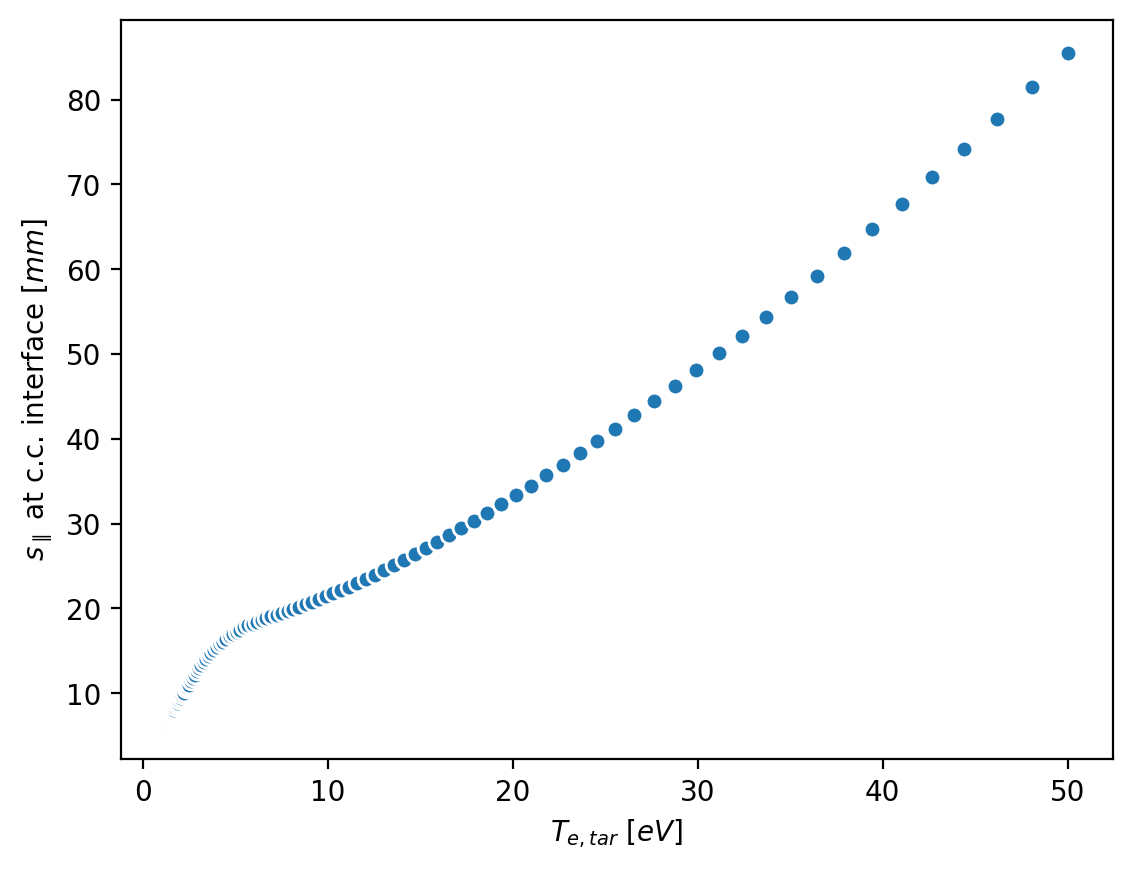

In [6]:
fig, ax = plt.subplots(dpi=200)

rcc_target_electron_temp_scan_for_fit["s_parallel_at_cc_interface"].pint.to(ureg.mm).plot.scatter()

ax.set_xlabel("$T_{e,tar}$ [$eV$]")
ax.set_ylabel("$s_\\parallel$ at c.c. interface [$mm$]")

Are we introducing a large error if we use a fixed regression for the convective region, as we vary the parameters?

The approximation isn't perfect, but we're accurate to within about 30% using a single regression.

/Users/tbody/Projects/raddivmom2/.venv/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/tbody/Projects/raddivmom2/.venv/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


/Users/tbody/Projects/raddivmom2/.venv/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


/Users/tbody/Projects/raddivmom2/.venv/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/tbody/Projects/raddivmom2/.venv/lib/python3.12/site-packages/xarray/core/computation.py:831: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


/var/folders/x2/fhfghwm566d83ws71kgzj86c0000gp/T/ipykernel_7944/2750153801.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


Text(0.5, 0, '$T_{e,tar}$ [eV]')

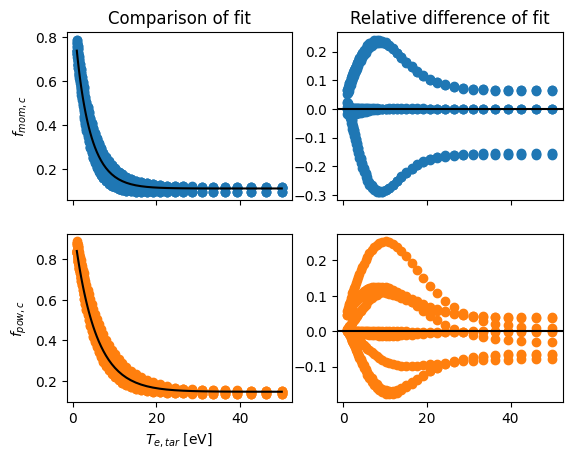

In [7]:
Te_tar = np.logspace(np.log10(1.0), np.log10(50))

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)

fmom_coeffs = reference_fit_coeffs["fmom_coeffs"]
fpow_coeffs = reference_fit_coeffs["fpow_coeffs"]
reference_fmom_fit = temperature_fit_function(Te_tar, fmom_coeffs["amplitude"], fmom_coeffs["width"], fmom_coeffs["shape"])
reference_fpow_fit = temperature_fit_function(Te_tar, fpow_coeffs["amplitude"], fpow_coeffs["width"], fpow_coeffs["shape"])

for qtar in [0.1, 1.0, 10]:
    for cz in [0.1, 1.0, 10]:

        ds = build_rcc_dataset(
            heat_flux_perp_to_target = qtar * ureg.MW / ureg.m**2,
            target_electron_temp  = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1.0), np.log10(50)), ureg.eV, dims="target_electron_temp"),
            impurity_fraction        = cz * ureg.percent,
            run_rcc_model_to_cc_interface = True,
        )

        fit_coeffs = determine_fmomc_and_fpowc_fit_functions(ds)
        fmom_coeffs = fit_coeffs["fmom_coeffs"]
        fpow_coeffs = fit_coeffs["fpow_coeffs"]

        fmom_fit = temperature_fit_function(Te_tar, fmom_coeffs["amplitude"], fmom_coeffs["width"], fmom_coeffs["shape"])
        fpow_fit = temperature_fit_function(Te_tar, fpow_coeffs["amplitude"], fpow_coeffs["width"], fpow_coeffs["shape"])
        axs[0][0].scatter(Te_tar, fmom_fit, c="C0")
        axs[1][0].scatter(Te_tar, fpow_fit, c="C1")

        axs[0][1].scatter(Te_tar, (fmom_fit - reference_fmom_fit) / reference_fmom_fit, c="C0")
        axs[1][1].scatter(Te_tar, (fpow_fit - reference_fpow_fit) / reference_fpow_fit, c="C1")

axs[0][0].plot(Te_tar, reference_fmom_fit, c="k")
axs[1][0].plot(Te_tar, reference_fpow_fit, c="k")
axs[0][1].axhline(0.0, color="k")
axs[1][1].axhline(0.0, color="k")

axs[0][0].set_title("Comparison of fit")
axs[0][1].set_title("Relative difference of fit")

axs[0][0].set_ylabel("$f_{mom,c}$")
axs[1][0].set_ylabel("$f_{pow,c}$")
axs[-1][0].set_xlabel("$T_{e,tar}$ [eV]")

## The role of the target heat flux

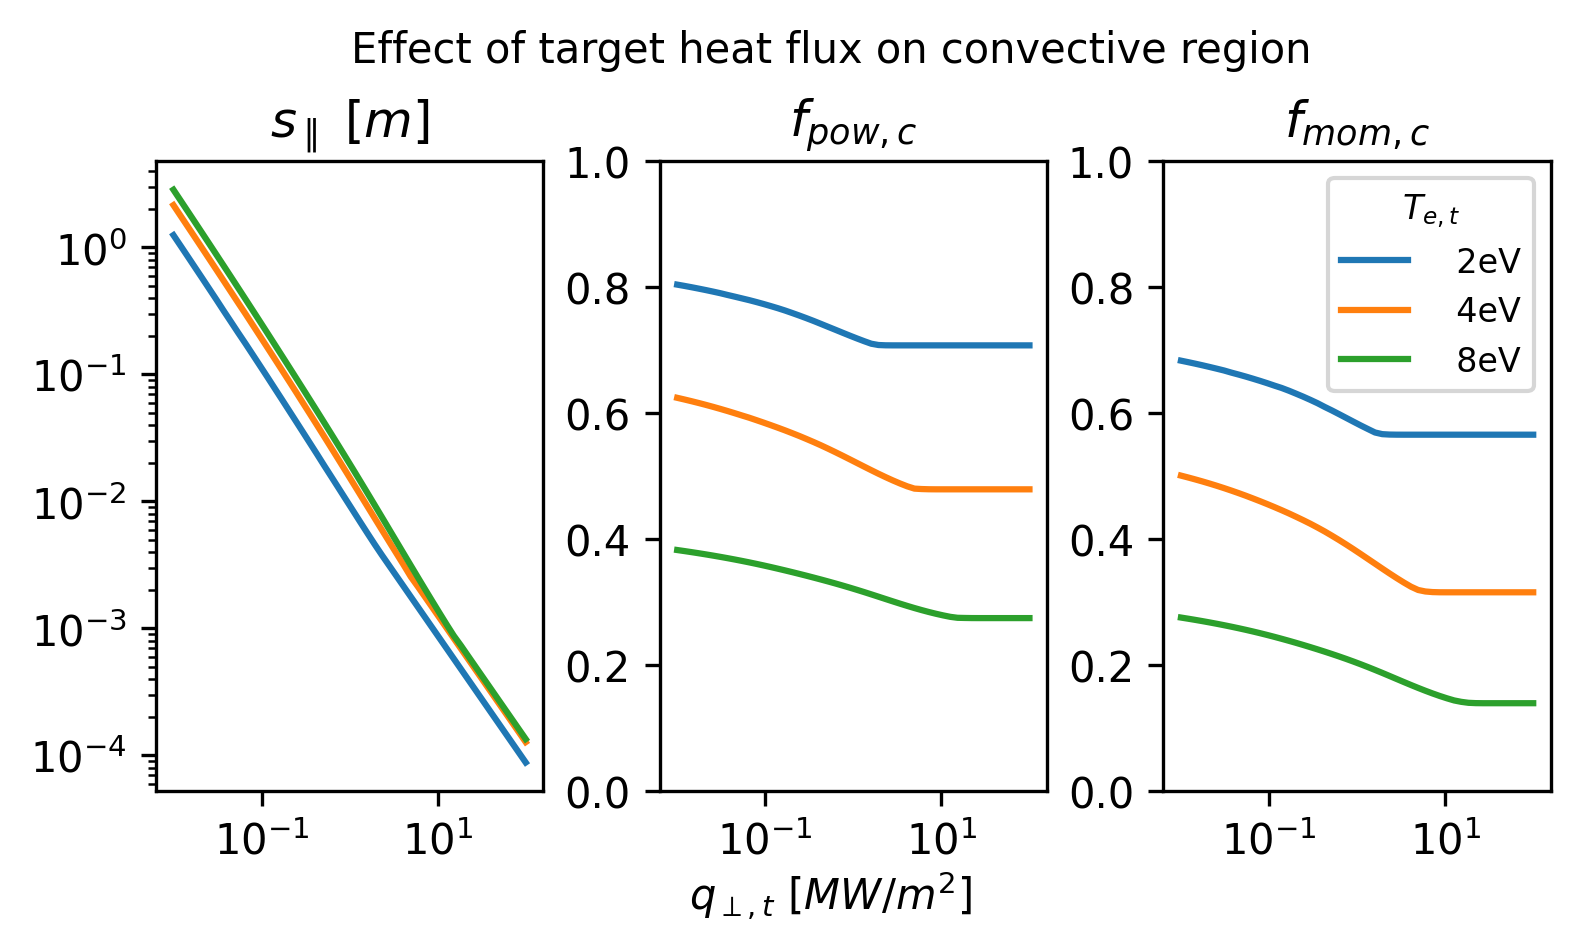

In [8]:
from matplotlib.lines import Line2D

rcc_target_heat_flux_scan = build_rcc_dataset(
    heat_flux_perp_to_target = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(0.01), np.log10(100.0), num=50), ureg.MW / ureg.m**2, dims="heat_flux_perp_to_target"),
    target_electron_temp  = extended_lengyel.promote_to_coordinate([2, 4, 8], ureg.eV, dims="target_electron_temp"),
    impurity_fraction        = 1.0 * ureg.percent,
    run_rcc_model_to_cc_interface = True,
)

fig, axs = plt.subplots(ncols=3, sharex=True, sharey=False, dpi=300, figsize=(6,3.0))
kwargs = dict(add_legend = False, _labels=False)

rcc_target_heat_flux_scan["s_parallel_at_cc_interface"].plot.line(hue="dim_target_electron_temp", xscale="log", ax=axs[0], **kwargs)
axs[0].set_title("$s_\\parallel$ [$m$]")
rcc_target_heat_flux_scan["SOL_power_loss_fraction_in_convection_layer"].plot.line(hue="dim_target_electron_temp", xscale="log", ax=axs[1], **kwargs)
axs[1].set_title("$f_{pow,c}$")
rcc_target_heat_flux_scan["SOL_momentum_loss_fraction_in_convection_layer"].plot.line(hue="dim_target_electron_temp", xscale="log", ax=axs[2], **kwargs)
axs[2].set_title("$f_{mom,c}$")

handles = [element for element in axs[2].get_children() if isinstance(element, Line2D)]
axs[2].legend(handles,
              [f"{val:3.2g}eV" for val in magnitude_in_units(rcc_target_heat_flux_scan["target_electron_temp"], ureg.eV)],
              title="$T_{e,t}$", fontsize=8, title_fontsize=8

)

axs[0].set_yscale("log")
axs[1].set_ylim(0, 1)
axs[2].set_ylim(0, 1)

fig.subplots_adjust(wspace=0.3, bottom=0.15, top=0.85)

fig.text(0.5, 0.02, "$q_{\\perp,t}$ [$MW/m^2$]", ha="center")
fig.text(0.5, 0.96, "Effect of target heat flux on convective region", ha="center")

fig.savefig(extended_lengyel.directories.output_dir / "target_heat_flux_convective.png", dpi=300)

As we increase $q_{tar}$, the convective region shrinks.

Covariance matrix condition number: 42644.630909795356, diagonal elements: [1.39724253e-09 7.46646656e-07]
A: 0.0102 +/- 3.73797e-05
m: -1.04452 +/- 0.000864087 eV



Text(0.5, 1.0, 'Convective layer expands as $q_{tar}$ decreases')

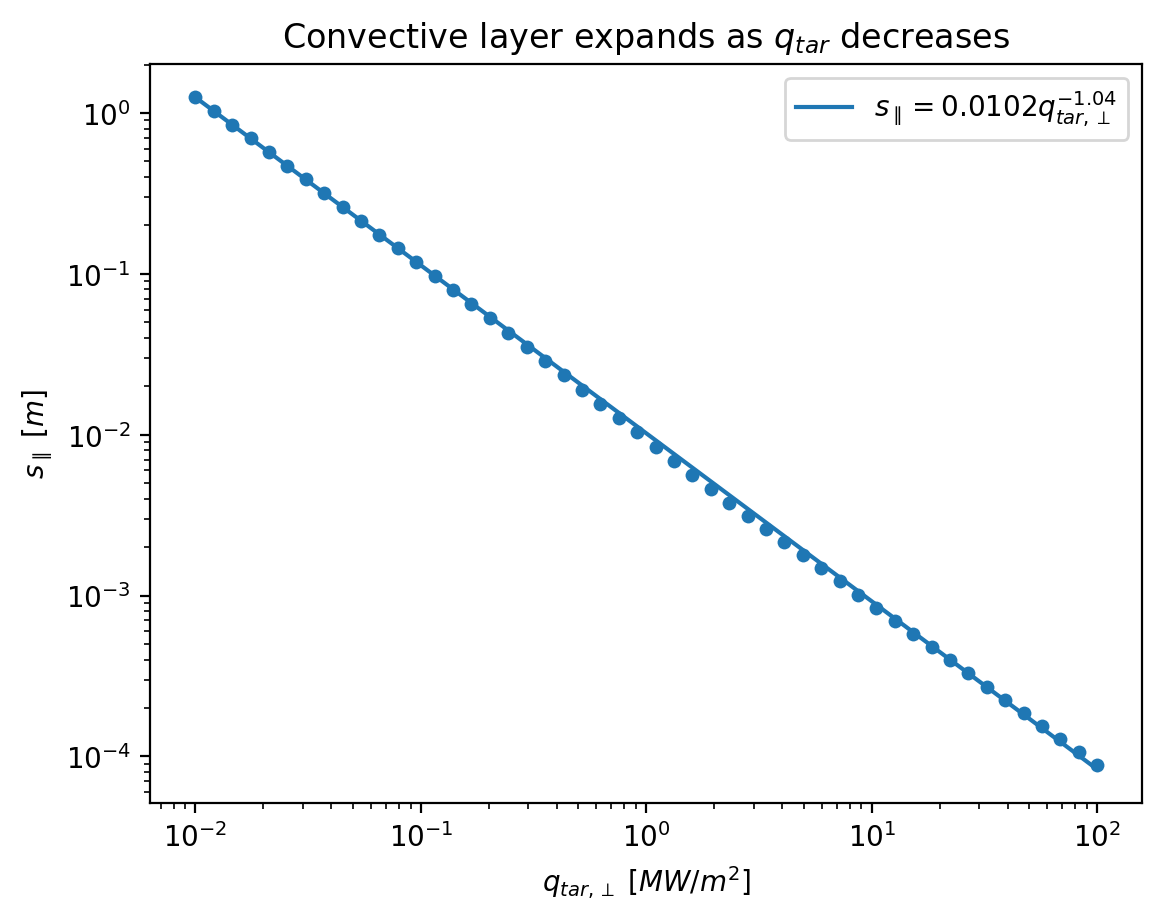

In [9]:
def determine_s_parallel_fit_coefficients(x, y, info=True):
    """Fit a power-law function to the data."""
    def power_law(x, A, m):
        return A * np.power(x, m)

    popt, pcov = curve_fit(
        power_law,
        xdata = x.where(~np.isnan(y), drop=True),
        ydata = y.where(~np.isnan(y), drop=True),
    )

    p_sigma = np.sqrt(np.diag(pcov))

    if info:
        print(f"Covariance matrix condition number: {np.linalg.cond(pcov)}, diagonal elements: {np.diag(pcov)}")
        print(
            f"A: {popt[0]:.6g} +/- {p_sigma[0]:.6g}\n"
            f"m: {popt[1]:.6g} +/- {p_sigma[1]:.6g} eV\n"
        )

    coeffs = dict(
        amplitude = float(popt[0]),
        power = float(popt[1]),
        amplitude_uncertainty = float(p_sigma[0]),
        power_uncertainty = float(p_sigma[1]),
    )

    return coeffs, lambda x: power_law(x, *popt)

fig, ax = plt.subplots(dpi=200)

rcc_target_heat_flux_scan["s_parallel_at_cc_interface"].isel(dim_target_electron_temp=0, drop=True).plot.scatter(xscale="log", yscale="log")

s_parallel_fit_coeffs, s_parallel_fit = determine_s_parallel_fit_coefficients(
    magnitude_in_units(rcc_target_heat_flux_scan["heat_flux_perp_to_target"], ureg.MW / ureg.m**2),
    magnitude_in_units(rcc_target_heat_flux_scan["s_parallel_at_cc_interface"].isel(dim_target_electron_temp=0), ureg.m)
)

ax.plot(magnitude_in_units(rcc_target_heat_flux_scan["heat_flux_perp_to_target"], ureg.MW / ureg.m**2),
        s_parallel_fit(magnitude_in_units(rcc_target_heat_flux_scan["heat_flux_perp_to_target"], ureg.MW / ureg.m**2)),
        label=f"$s_\\parallel = {s_parallel_fit_coeffs['amplitude']:.3g} q_{{tar,\\perp}}^{{{s_parallel_fit_coeffs['power']:.3g}}}$"
)
ax.legend()

ax.set_xlabel("$q_{tar,\\perp}$ [$MW/m^2$]")
ax.set_ylabel("$s_\\parallel$ [$m$]")
ax.set_title("Convective layer expands as $q_{tar}$ decreases")

## Looking at the relationship between $f_{mom}$ and $f_{pow}$

The momentum loss and power loss factors are clearly related in this model. There's probably a neat explanation as to why, but I haven't figured it out yet.

Text(0, 0.5, '$f_{pow,c}$')

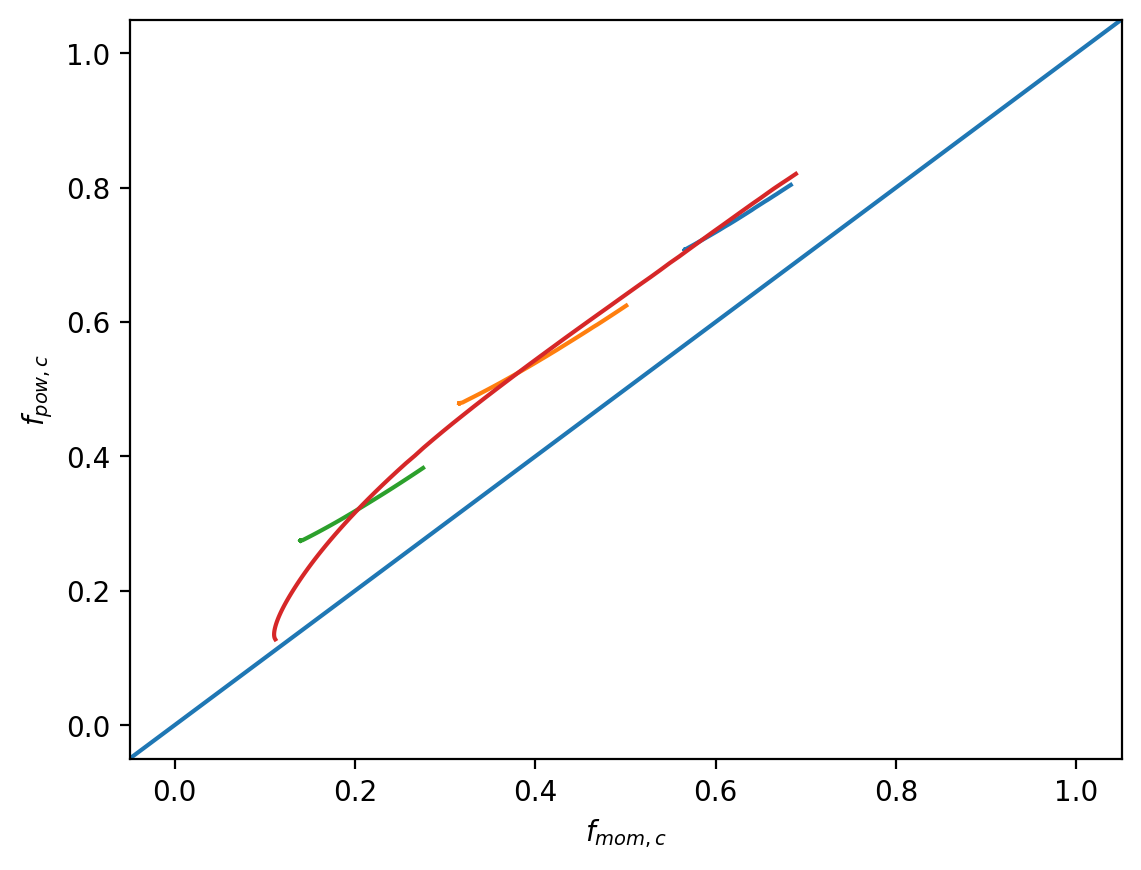

In [10]:
fig, ax = plt.subplots(dpi=200)

ax.plot(rcc_target_heat_flux_scan["SOL_momentum_loss_fraction_in_convection_layer"], rcc_target_heat_flux_scan["SOL_power_loss_fraction_in_convection_layer"])
ax.plot(rcc_target_electron_temp_scan_for_fit["SOL_momentum_loss_fraction_in_convection_layer"], rcc_target_electron_temp_scan_for_fit["SOL_power_loss_fraction_in_convection_layer"])
ax.axline((0, 0), (1, 1))

ax.set_xlabel("$f_{mom,c}$")
ax.set_ylabel("$f_{pow,c}$")

As a sanity check, if we compare the spatial Lengyel model with these fit functions to the full Kallenbach model, we should get approximately (but not exactly) the same upstream parameters.

In [11]:
def build_dataset(
    run_lengyel_model = True,
    **overrides
):
    if run_lengyel_model: 
        algorithm = cfspopcon.CompositeAlgorithm.from_list([
            "initialize_kallenbach_model",
            "calc_electron_temp_from_cc_fit",
            "calc_electron_density_from_cc_fit",
            "calc_power_loss_from_cc_fit",
            "calc_parallel_heat_flux_from_conv_loss",
            "ignore_s_parallel_width_for_cc_interface",
            "run_spatial_lengyel_model",
            "postprocess_spatial_lengyel_model"
        ])
    else:
        algorithm = cfspopcon.CompositeAlgorithm.from_list([
            "initialize_kallenbach_model",
            "run_kallenbach_model",
            "postprocess_kallenbach_model"
        ])

    ds = xr.Dataset(data_vars=extended_lengyel.read_config(
        elements=["base", "target_constraints"],
        keys=algorithm.input_keys,
        allowed_missing=algorithm.default_keys,
        overrides=overrides,
    ))
    algorithm.validate_inputs(ds)
    ds = algorithm.update_dataset(ds)

    return ds

def promote_to_coordinate(array, units, dims): 
    return xr.DataArray(array * units, coords={f"dim_{dims}": array})

inputs = dict(
    heat_flux_perp_to_target = promote_to_coordinate(np.logspace(np.log10(0.1), np.log10(10.0), num=10), ureg.MW / ureg.m**2, dims="heat_flux_perp_to_target"),
    target_electron_temp  = promote_to_coordinate(np.logspace(np.log10(2.0), np.log10(50), num=10), ureg.eV, dims="target_electron_temp"),
    impurity_fraction        = promote_to_coordinate([1.0, 2.0, 4.0], ureg.percent, dims="impurity_fraction"),
)

lengyel_ds       = build_dataset(**inputs, run_lengyel_model = True)
rcc_reference_ds = build_dataset(**inputs, run_lengyel_model = False)

/Users/tbody/Projects/raddivmom2/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Text(0, 0.5, 'Spatial Lengyel')

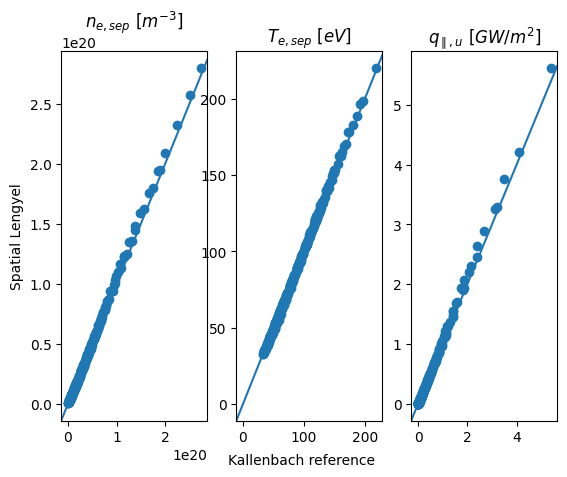

In [12]:
fig, axs = plt.subplots(ncols=3)

axs[0].scatter(
    rcc_reference_ds["separatrix_electron_density"].pint.to(ureg.m**-3).broadcast_like(lengyel_ds["separatrix_electron_density"]),
    lengyel_ds["separatrix_electron_density"].pint.to(ureg.m**-3),
)
axs[0].set_title("$n_{e,sep}$ [$m^{-3}$]")

axs[1].scatter(
    rcc_reference_ds["separatrix_electron_temp"].pint.to(ureg.eV).broadcast_like(lengyel_ds["separatrix_electron_temp"]),
    lengyel_ds["separatrix_electron_temp"].pint.to(ureg.eV),
)
axs[1].set_title("$T_{e,sep}$ [$eV$]")

axs[2].scatter(
    rcc_reference_ds["q_parallel"].pint.to(ureg.GW/ureg.m**2).broadcast_like(lengyel_ds["q_parallel"]),
    lengyel_ds["q_parallel"].pint.to(ureg.GW/ureg.m**2),
)
axs[2].set_title("$q_{\\parallel,u}$ [$GW/m^2$]")

for ax in axs:
    ax.axline((0.0, 0.0), slope=1.0)

fig.text(0.5, 0.02, "Kallenbach reference", ha="center")
axs[0].set_ylabel("Spatial Lengyel")

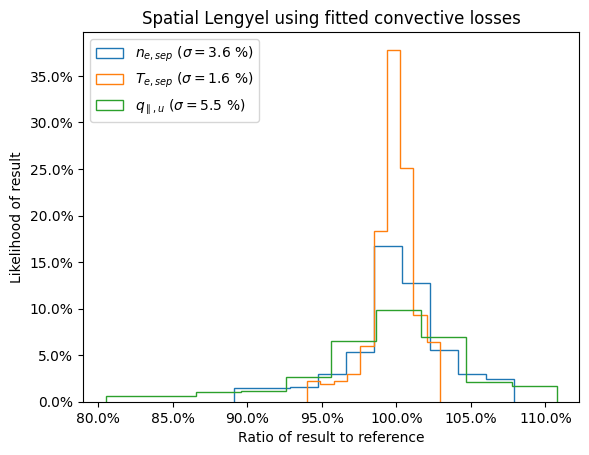

In [13]:
from matplotlib.ticker import PercentFormatter

rtol_separatrix_electron_density = (lengyel_ds["separatrix_electron_density"] / rcc_reference_ds["separatrix_electron_density"].broadcast_like(lengyel_ds["separatrix_electron_density"]))
rtol_separatrix_electron_temp = (lengyel_ds["separatrix_electron_temp"] / rcc_reference_ds["separatrix_electron_temp"].broadcast_like(lengyel_ds["separatrix_electron_temp"]))
rtol_q_parallel = (lengyel_ds["q_parallel"] / rcc_reference_ds["q_parallel"].broadcast_like(lengyel_ds["q_parallel"]))

fig, ax = plt.subplots()

kwargs = dict(histtype="step", density=True)

for label, result in {
    "$n_{e,sep}$": rtol_separatrix_electron_density,
    "$T_{e,sep}$": rtol_separatrix_electron_temp,
    "$q_{\\parallel,u}$": rtol_q_parallel,
}.items():
    std = result.std().item().to(ureg.percent)
    result.plot.hist(ax=ax, label=f"{label} ($\\sigma=${std:~.1f})", **kwargs)

ax.legend(loc="upper left")
ax.set_ylabel("Likelihood of result")
ax.set_xlabel("Ratio of result to reference")
ax.set_title("Spatial Lengyel using fitted convective losses")

ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))

plt.savefig(extended_lengyel.directories.output_dir / "rtol_for_spatial_lengyel_using_fitted_losses.png", dpi=300)

Is there a critical temperature (similar to the Siccinio model)?

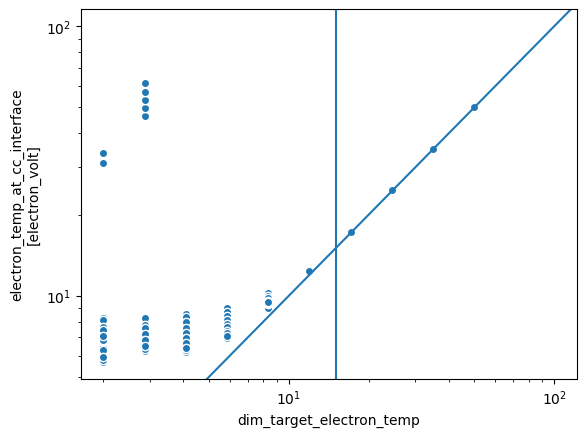

In [14]:
rcc_reference_ds["electron_temp_at_cc_interface"].plot.scatter(x="dim_target_electron_temp", xscale="log", yscale="log")
plt.axvline(15.0)
plt.axline((10, 10), (100, 100))

What about for other species?

Fitting fmom
Covariance matrix condition number: 3811.020890983101, diagonal elements: [7.36924906e-07 1.28091305e-03 5.17363093e-05]
amplitude: 0.886 \pm 0.0009
width: 3.84 \pm 0.04
shape: 0.823 \pm 0.007
Fitting fpow
Covariance matrix condition number: 5029.3683076706775, diagonal elements: [4.08940434e-06 8.38210448e-03 1.96357101e-04]
amplitude: 0.853 \pm 0.002
width: 5.34 \pm 0.09
shape: 0.943 \pm 0.01
Fitting fdens
Covariance matrix condition number: 5314.354483145796, diagonal elements: [4.84907903e-07 1.15052697e-03 3.98085951e-04]
amplitude: 0.559 \pm 0.0007
width: 2.06 \pm 0.03
shape: 0.984 \pm 0.02


Fitting fmom
Covariance matrix condition number: 3754.817429531419, diagonal elements: [7.64891594e-07 1.31262772e-03 5.44793146e-05]
amplitude: 0.886 \pm 0.0009
width: 3.82 \pm 0.04
shape: 0.829 \pm 0.007
Fitting fpow
Covariance matrix condition number: 4588.621988032725, diagonal elements: [3.80641620e-06 7.30716396e-03 2.03457303e-04]
amplitude: 0.853 \pm 0.002
width: 5.12 \pm 0.09
shape: 0.965 \pm 0.01
Fitting fdens
Covariance matrix condition number: 5501.175054320669, diagonal elements: [4.87721181e-07 1.19994843e-03 4.12865275e-04]
amplitude: 0.559 \pm 0.0007
width: 2.02 \pm 0.03
shape: 0.956 \pm 0.02


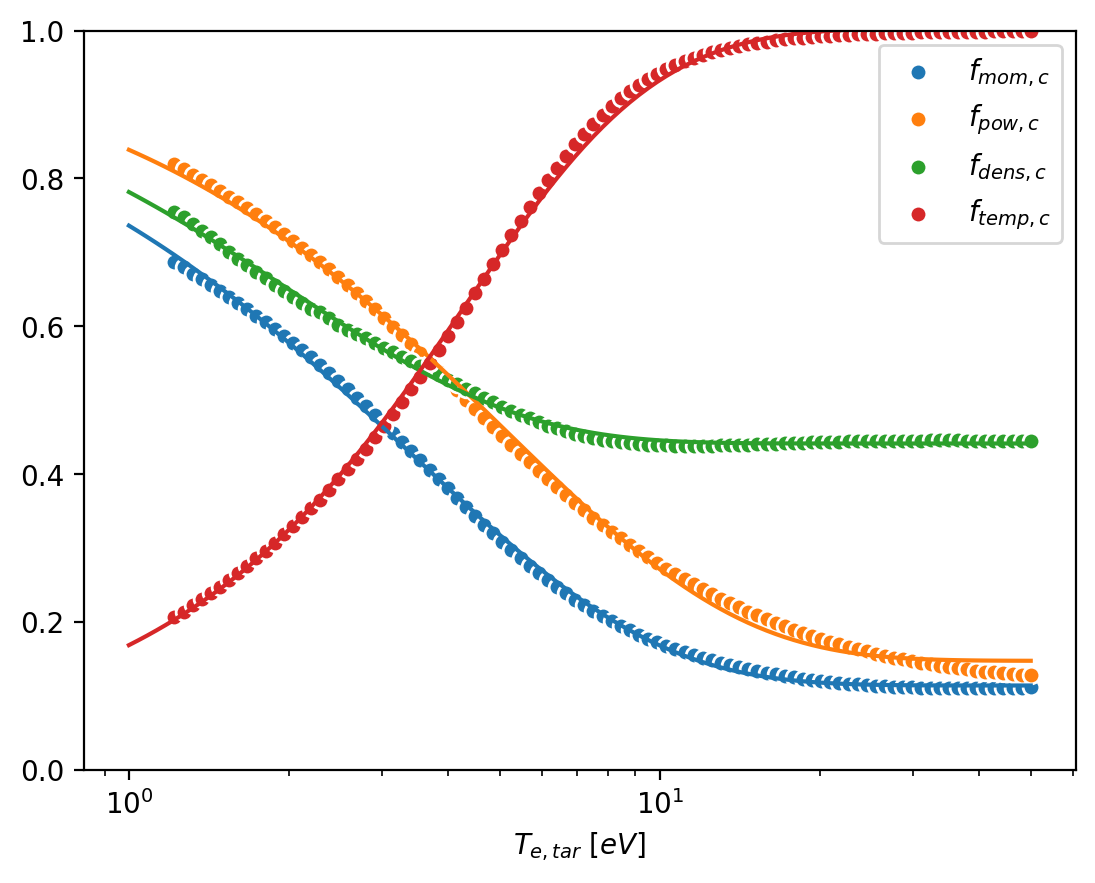

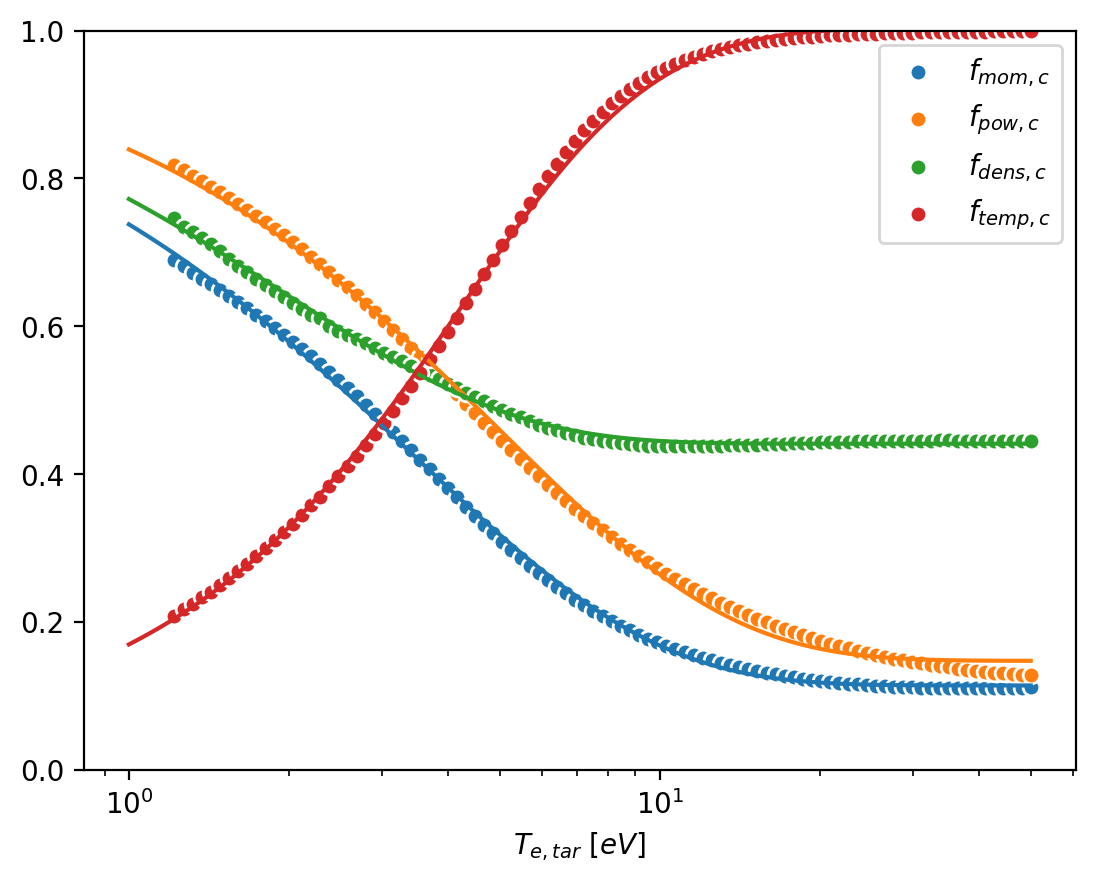

In [15]:
from cfspopcon.named_options import AtomicSpecies

for impurity_species in [AtomicSpecies.Argon, AtomicSpecies.Neon]:

    rcc_target_electron_temp_scan_for_fit = build_rcc_dataset(
        heat_flux_perp_to_target      = 1.0 * ureg.MW / ureg.m**2,
        target_electron_temp       = promote_to_coordinate(np.logspace(np.log10(1.0), np.log10(50), num=100), ureg.eV, dims="target_electron_temp"),
        impurity_fraction             = 1.0 * ureg.percent,
        run_rcc_model_to_cc_interface = True,
        impurity_species         = impurity_species
    )

    reference_fit_coeffs = determine_fmomc_and_fpowc_fit_functions(rcc_target_electron_temp_scan_for_fit, info=True, save=False, plot=True)